# Constant Interval

We will choose a fixed parameter a > 0 for this strategy. In the beginning, we will provide liquidity in a symmetric interval around the current price. This interval will never be adjusted. More specifically, we will choose the interval [p − a, p + a], where p is the price at the beginning.
For the USDC-ETH pool, we will choose a ∈ [10, 40000], which means that the size is between 10 and 40000 basis points, or 0.1% and 400%. It does not make sense to choose another a because, at any time, the price is always in [p−a,p+a].

Import code dependencies

In [1]:
from typing import List

import pandas as pd
from matplotlib.pylab import plt
import matplotlib.dates as mdates
from datetime import date

from demeter import MarketInfo, Actuator, MarketInfo, TokenInfo, Strategy, ChainType
from demeter.broker import AccountStatus
from demeter.result import performance_metrics, round_results
from demeter.uniswap import UniV3Pool, UniLpMarket

pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

Custom Constant Interval strategy with code to add liquidity at constant interval around current price.

In [2]:
class ConstantIntervalStrategy(Strategy):
    def __init__(self, a=100):
        super().__init__()
        self.a = a

    def initialize(self):
        market: UniLpMarket = self.markets[market_key]
        init_price = market.market_status.data.price
        market.even_rebalance(init_price)  # rebalance all reserve token#
        # new_position(self, baseToken, quoteToken, usd_price_a, usd_price_b):
        # what is  base/quote "https://corporatefinanceinstitute.com/resources/knowledge/economics/currency-pair/"
        market.add_liquidity(init_price - self.a, init_price + self.a)
        super().__init__()

Main logic to run Actuator, init two token and market with key "market1"

I think that UniV3Pool could be made as general Pool class and then TokenInfo could be using it to initalize? 

In [3]:
API_KEY = ""
POOL_ADDRESS = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640".lower()
START_DATE = date(2024, 8, 1)
END_DATE = date(2024, 9, 1)
pool = UniV3Pool(pool_address=POOL_ADDRESS, api_key=API_KEY)
market_key = MarketInfo("market1")
actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)
broker.add_market(market)
broker.set_balance(pool.token0, 2000)  # For USDC
broker.set_balance(pool.token1, 0)     # For ETH

In [6]:
actuator.strategy = ConstantIntervalStrategy(100)

market.data_path = "../data"
market.load_data(ChainType.polygon.name, "0x45dda9cb7c25131df268515131f647d726f50608", date(2023, 8, 13),
                 date(2023, 8, 17))
actuator.set_price(market.get_price_from_data())
# actuator.run()  # run test

2024-10-05 15:36:12,822 - INFO - start load files from 2023-08-13 to 2023-08-17...
2024-10-05 15:36:12,854 - INFO - load file complete, preparing...
2024-10-05 15:36:12,942 - INFO - data has been prepared


Run actuator with evaluators and save result to files

In [7]:
market.data.head(2)

,netAmount0,netAmount1,closeTick,openTick,lowestTick,highestTick,inAmount0,inAmount1,currentLiquidity,open,price,low,high,volume0,volume1
2023-08-13 00:00:00,-1970524626,1066799650715290921,201101.0,201101.0,201101.0,201101.0,0,1066799650715290921,2391553663290390168,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,0,1.066799650715290921
2023-08-13 00:01:00,0,0,201101.0,201101.0,201101.0,201101.0,0,0,2391553663290390168,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,0,0


In [8]:
actuator.run()

2024-10-05 15:36:22,409 - INFO - Qute token is USDC
2024-10-05 15:36:22,410 - INFO - init strategy...
2024-10-05 15:36:22,412 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [00:00<00:00, 9412.39it/s]
2024-10-05 15:36:23,193 - INFO - main loop finished
2024-10-05 15:36:23,250 - INFO - Print actuator summary
2024-10-05 15:36:23,268 - INFO - Backtesting finished, execute time 0.860663890838623s


Final account status                              
Token balance in broker       
USDC      :0                        WETH      :0.026738035              
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :WETH                     fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1        liquidity
0      200570      201660  2.5731274  0.0017363770  843762970646576

Quote by: USDC
Account balance history                           
l1                  net_value tokens               market1                                                                                          price     
l2                              USDC        WETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count      WETH USDC
2023-08-13 00:00:00 1999.5002      0 0.026738035  1950.085    1.8812218e-07                 0       0.51421585     

In [9]:
print({k: round(v, 5) for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"][pool.token1_str]
).items()})

TypeError: type Timestamp doesn't define __round__ method

In [10]:
# does not work even when we check for instance
# not sure where is the problem
print({k: round_results(v, 5) for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"][pool.token1_str]
).items()})

AttributeError: 'Timestamp' object has no attribute 'items'

In [11]:
#need to use not rounded value

In [12]:
print({k: v for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"][str(pool.token1)]
).items()})

{Start period: Timestamp('2023-08-13 00:00:00'), End period: Timestamp('2023-08-17 23:59:00'), Duration: Timedelta('5 days 00:00:00'), Return: -146.6138841801569, Rate of Return: -0.07332526526151262, APR: -0.9961479267723489, Max Draw Down: 0.12455120134379453, Sharpe Ratio: -2.3464267086029222, Volatility: 0.4373236645364145, Alpha: -0.037750176935095525, Beta: 0.9594628978875338, Benchmark return rate: -0.08898447514180896, Benchmark APR: -0.9988898496725327}


In [13]:
# This plotter needs an automatic detection of what pool and therefore pai we are using
# We could use pool info

#Set matplotlib to show formatted account status
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

#Make plot about price and account value / position net value
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo, pool: UniV3Pool):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    # this str 
    value_in_account = account_status["tokens"][pool.token0_str] + account_status["tokens"][pool.token1_str] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_80055/1818749377.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


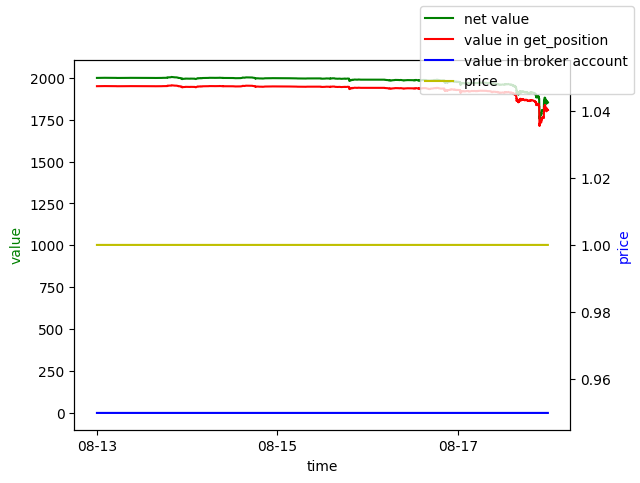

In [15]:
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[pool.quote_token_str], market_key, pool)

### Let's try it with the newer Ethereum data 

In [17]:
API_KEY = ""
POOL_ADDRESS = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640".lower()
START_DATE = date(2024, 8, 1)
END_DATE = date(2024, 9, 1)
pool = UniV3Pool(pool_address=POOL_ADDRESS, api_key=API_KEY)
market_key = MarketInfo("market1")
actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)
broker.add_market(market)
broker.set_balance(pool.token0, 2000)  # For USDC
broker.set_balance(pool.token1, 0)     # For ETH
actuator.strategy = ConstantIntervalStrategy(200)

market.data_path = ""
market.load_data(ChainType.ethereum.name, "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", date(2024, 7, 2),
                 date(2024, 8, 1))
actuator.set_price(market.get_price_from_data())
# actuator.run()  # run test

2024-10-05 15:47:34,642 - INFO - start load files from 2024-07-02 to 2024-08-01...
2024-10-05 15:47:34,791 - INFO - load file complete, preparing...
2024-10-05 15:47:35,267 - INFO - data has been prepared


Run actuator with evaluators and save result to files

In [18]:
actuator.run()

2024-10-05 15:47:38,973 - INFO - Qute token is USDC
2024-10-05 15:47:38,973 - INFO - init strategy...
2024-10-05 15:47:38,977 - INFO - start main loop...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 44640/44640 [00:04<00:00, 9631.05it/s]
2024-10-05 15:47:43,615 - INFO - main loop finished
2024-10-05 15:47:43,948 - INFO - Print actuator summary
2024-10-05 15:47:44,049 - INFO - Backtesting finished, execute time 5.079678058624268s


Final account status                              
Token balance in broker       
USDC      :0                        WETH      :0.013504318              
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :WETH                     fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0     pending1        liquidity
0      194320      195480  39.908089  0.012149612  582470219044557

Quote by: USDC
Account balance history                           
l1                  net_value tokens               market1                                                                                          price     
l2                              USDC        WETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count      WETH USDC
2024-07-02 00:00:00 1999.5008      0 0.013504318 1953.0381    2.5766256e-07                 0       0.27707167       

In [20]:
print({k: v for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"][str(pool.token1)]
).items()})

{Start period: Timestamp('2024-07-02 00:00:00'), End period: Timestamp('2024-08-01 23:59:00'), Duration: Timedelta('31 days 00:00:00'), Return: -31.277575140650924, Rate of Return: -0.015642692291407356, APR: -0.16942398417444182, Max Draw Down: 0.17456711431735525, Sharpe Ratio: -0.419573758156524, Volatility: 0.47530137502101366, Alpha: 0.3284221739735472, Beta: 0.8740607951708604, Benchmark return rate: -0.06909348496087198, Benchmark APR: -0.5695784102187615}


In [22]:
# is this graph correct regarding value in broker amount? 

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_80055/1818749377.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


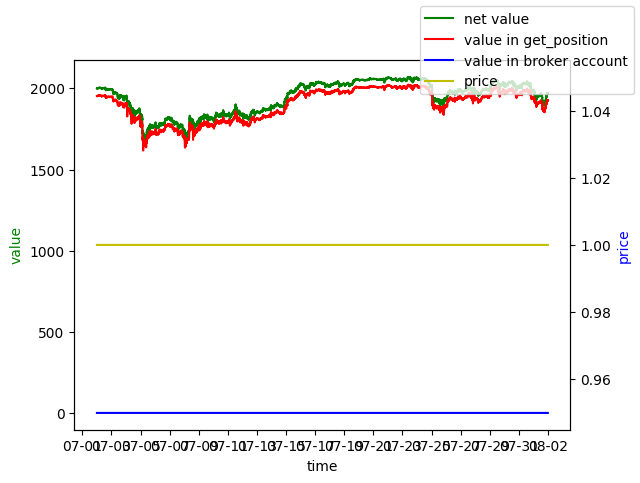

In [21]:
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[pool.quote_token_str], market_key, pool)